# Aphid-Ladybeetle study

## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

In [1]:
import pandas as pd

aphid_data = pd.read_csv('../data/simple/aphid.csv')
ladybeetle_data = pd.read_csv('../data/simple/ladybeetle.csv')

In [2]:
aphid_data

,variable,time,x,density
0,aphid,0,1.0,19.834058
1,aphid,0,2.0,70.841565
2,aphid,0,3.0,264.045832
3,aphid,0,4.0,620.308179
4,aphid,0,5.0,434.176215
5,aphid,0,6.0,96.918214
6,aphid,0,7.0,38.285263
7,aphid,0,8.0,15.211379
8,aphid,1,1.0,11.940299
9,aphid,1,2.0,74.626866


Normalizing spatial data with the following mapping $[0, 9] \to [0, 1]$:

In [3]:
aphid_data['x'] = aphid_data['x'].apply(lambda x: x / 9)
ladybeetle_data['x'] = ladybeetle_data['x'].apply(lambda x: x / 9)

In [4]:
aphid_data

,variable,time,x,density
0,aphid,0,0.111111,19.834058
1,aphid,0,0.222222,70.841565
2,aphid,0,0.333333,264.045832
3,aphid,0,0.444444,620.308179
4,aphid,0,0.555556,434.176215
5,aphid,0,0.666667,96.918214
6,aphid,0,0.777778,38.285263
7,aphid,0,0.888889,15.211379
8,aphid,1,0.111111,11.940299
9,aphid,1,0.222222,74.626866


In [5]:
ladybeetle_data

,variable,time,x,density
0,ladybeetle,0,0.111111,2.791089
1,ladybeetle,0,0.222222,2.734275
2,ladybeetle,0,0.333333,2.697629
3,ladybeetle,0,0.444444,2.617913
4,ladybeetle,0,0.555556,2.686136
5,ladybeetle,0,0.666667,2.669769
6,ladybeetle,0,0.777778,2.655327
7,ladybeetle,0,0.888889,2.638960
8,ladybeetle,1,0.111111,1.000000
9,ladybeetle,1,0.222222,2.666667


Retrieving IC data:

In [6]:
aphid_ic_data = aphid_data[aphid_data.time == 0].copy()
ladybeetle_ic_data = ladybeetle_data[ladybeetle_data.time == 0].copy()

In [7]:
aphid_ic_data

,variable,time,x,density
0,aphid,0,0.111111,19.834058
1,aphid,0,0.222222,70.841565
2,aphid,0,0.333333,264.045832
3,aphid,0,0.444444,620.308179
4,aphid,0,0.555556,434.176215
5,aphid,0,0.666667,96.918214
6,aphid,0,0.777778,38.285263
7,aphid,0,0.888889,15.211379


In [8]:
ladybeetle_ic_data

,variable,time,x,density
0,ladybeetle,0,0.111111,2.791089
1,ladybeetle,0,0.222222,2.734275
2,ladybeetle,0,0.333333,2.697629
3,ladybeetle,0,0.444444,2.617913
4,ladybeetle,0,0.555556,2.686136
5,ladybeetle,0,0.666667,2.669769
6,ladybeetle,0,0.777778,2.655327
7,ladybeetle,0,0.888889,2.638960


### Ladybird beetles IC

For ladybird beetles is quite simple, we just need to take the mean:

In [9]:
ladybeetle_ic = ladybeetle_ic_data.density.values.mean()

ladybeetle_ic

2.6863873510629865

### Aphids IC

This is a more interesting case. Let's have a look on the points.

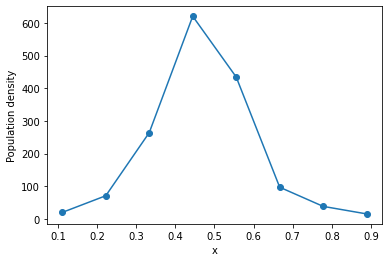

In [10]:
import matplotlib.pyplot as plt

plt.plot(aphid_ic_data.x.values, aphid_ic_data.density.values, '-o')
plt.xlabel('x')
plt.ylabel('Population density')
plt.show()

It quite resembles a gaussian. So let us fit a gaussian to it.

* Define a gaussian function:

In [11]:
import numpy as np
from typing import Union

def gaussian(
    x: Union[float, np.ndarray],
    scale_term: float,
    mu: float, 
    sigma: float
) -> Union[float, np.ndarray]:
    """
    A univariate gaussian function.
    
    :param x:
        The value to evaluate the gaussian function.
        
    :param scale_term:
        The proportional term that multiplicates the gaussian exponential
        term.
        
    :param mu:
        The mean for the gaussian function.
        
    :param sigma:
        The standard deviation.
        
    :return:
        A value, or an array of values, computed with the gaussian function.
    """
    exponential_term = np.exp(- 1.0 / 2.0 * ((x - mu) / sigma) ** 2.0)
    return scale_term * exponential_term

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [12]:
def calculate_least_squares_error(parameters, x_data, y_data, fitting_model):
    args = parameters
    y_model = fitting_model(x_data, *args)    
    residual = y_data - y_model
    return np.sum(residual ** 2.0)

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [13]:
from scipy import optimize


def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')
    

parameters_bounds = [(1e-5, 1000), (1e-5, 10), (1e-5, 1000)]
x_data = aphid_ic_data.x.values
y_data = aphid_ic_data.density.values
seed = 1234  # for the sake of reproducibility

result= optimize.differential_evolution(
    calculate_least_squares_error, 
    bounds=parameters_bounds, 
    args=(x_data, y_data, gaussian), 
    popsize=30,
    strategy='best1bin',
    tol=1e-8,
    recombination=0.7,
    maxiter=500,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
)

print(result)

differential_evolution step 1: f(x)= 355465
parameters = [195.63549367   5.37033824 643.01581751]

differential_evolution step 2: f(x)= 355462
parameters = [194.74637253   3.13392236 362.68744169]

differential_evolution step 3: f(x)= 355462
parameters = [194.74637253   6.23495022 628.58270298]

differential_evolution step 4: f(x)= 355462
parameters = [194.74637253   6.23495022 628.58270298]

differential_evolution step 5: f(x)= 355462
parameters = [194.74637253   6.23495022 628.58270298]

differential_evolution step 6: f(x)= 355462
parameters = [195.11978589   1.46632922 315.24891472]

differential_evolution step 7: f(x)= 355462
parameters = [194.97890531   1.06916256 378.5108227 ]

differential_evolution step 8: f(x)= 355462
parameters = [194.97890531   1.06916256 378.5108227 ]

differential_evolution step 9: f(x)= 355461
parameters = [1.94827062e+02 1.62294313e-01 3.24523254e+02]

differential_evolution step 10: f(x)= 355454
parameters = [195.35202734   0.22818005  48.32499638]

dif

* Retrieving the calibrated parameter values:

In [14]:
scale_term, mu, sigma = result.x

x = np.linspace(0, 1)
aphid_ic_points = gaussian(x, scale_term, mu, sigma)

* Plotting the fitted function to compare with data:

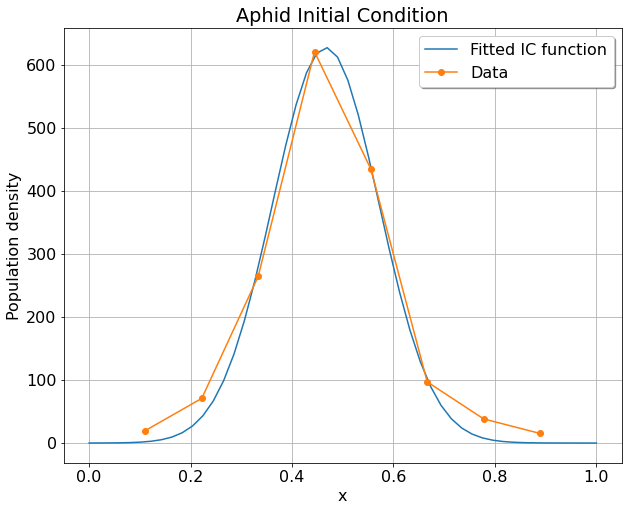

In [15]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})

plt.plot(x, aphid_ic_points, '-', label='Fitted IC function')
plt.plot(aphid_ic_data.x.values, aphid_ic_data.density.values, '-o', label='Data')

plt.title('Aphid Initial Condition')
plt.xlabel('x')
plt.ylabel('Population density')

plt.grid(True)
plt.legend(fancybox=True, shadow=True)

plt.savefig('fitted_ic.png', dpi=300)
plt.show()

## First model: classical Lotka-Volterra

The problem consists in solving the system:

\begin{equation}
\begin{aligned}
u_{t} &=D_{u} u_{x x}+f(u, v) \\
v_{t} &=D_{v} v_{x x}+g(u, v)
\end{aligned}
\end{equation}

in which $u$ is the prey and $v$ the predator, $D_u$ and $D_v$ are the diffusive coefficients, and $f(u, v)$ and $g(u, v)$ are the reactive terms that can have the following form:

\begin{equation}
\begin{array}{c}
f(u, v)=r u-a u v \\
g(u, v)=b a u v-m v
\end{array}
\end{equation}

with the constants $r, a, b, m > 0$.


### Forward simulation

In [16]:
from pde import (PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, 
                 CartesianGrid, MemoryStorage)
from pde import ExplicitSolver, ImplicitSolver, Controller, ScipySolver

# Species diffusivity coefficients (please be careful with these values)
Du = 0.67e-3  # gathered from Banks
Dv = 0.21e-2  # gathered from Banks

# Banks functional response 1 (case A)
r1 = 0.136
r2 = 0.48e-3
p = 0.032
i = 11.0
e1 = 0.0012
e2 = 20.9
e3 = 0.009

# Functional response (case A)
f_function = f"+ {r1} * u - {r2} * u * u - {p} * u * v"  # don't forget to put + (or -) sign in the beginning
g_function = f"+ {i} - ({e1} + {e2} * exp(- {e3} * u)) * v"

# (Dirichlet) Boundary condition example
bc_left = {"value": 0.0}  # both unknowns are set to zero, unfortunately
bc_right = {"value": 0.0}
bc = [bc_left, bc_right]

# Definition of PDE system
eq = PDE(
    {
        "u": f"{Du} * laplace(u)" + f_function,
        "v": f"{Dv} * laplace(v)" + g_function,
    },
    bc=bc  # comment here if you want to "free" the boundaries
)

# Defining the mesh
x_min, x_max = 0, 1
dx = 0.025
num_points_in_x = int((x_max - x_min) / dx)
grid = CartesianGrid(bounds=[[x_min, x_max]], shape=num_points_in_x)

# Initialize state (Initial Conditions)
u = ScalarField.from_expression(
    grid, 
    f"{scale_term} * exp(- 1.0 / 2.0 * ((x - {mu}) / {sigma}) ** 2.0)", 
    label="Prey"
)
v = ScalarField(grid, ladybeetle_ic, label="Predator")
state = FieldCollection([u, v])  # state vector

# Define time tracker to plot and animate
x_axis_limits = (x_min, x_max)
y_axis_limits = (0, 650)
tracker_plot_config = PlotTracker(show=True, plot_args={
        'ax_style': {'xlim': x_axis_limits, 'ylim': y_axis_limits},
    }
)
storage = MemoryStorage()
dt = 1e-2
trackers = [
    "progress",  # show progress bar during simulation
    "steady_state",  # abort if steady state is reached
    storage.tracker(interval=0.25),  # store data every simulation time unit
    tracker_plot_config,  # show images during simulation
]

# Select backend solver
# solver = ExplicitSolver(eq)  # Built-in explicit solver
solver = ScipySolver(eq, method='RK45', backend="numpy")  # SciPy solver

# Setup solver
controller = Controller(solver, t_range=[0, 2], tracker=trackers)
solve = controller.run(state, dt=dt)

Output()

Retrieving data stored spaced by 1.0 as time-records:

In [17]:
u_storage = storage.extract_field(0)
v_storage = storage.extract_field(1)

u_storage.data

[array([5.20234170e-02, 1.42270686e-01, 3.67536919e-01, 8.96923725e-01,
        2.06765963e+00, 4.50268515e+00, 9.26260422e+00, 1.79996322e+01,
        3.30417581e+01, 5.72969705e+01, 9.38575402e+01, 1.45236466e+02,
        2.12300575e+02, 2.93153892e+02, 3.82392312e+02, 4.71185196e+02,
        5.48457673e+02, 6.03064260e+02, 6.26401892e+02, 6.14626847e+02,
        5.69690512e+02, 4.98810334e+02, 4.12573086e+02, 3.22355689e+02,
        2.37924289e+02, 1.65886566e+02, 1.09257850e+02, 6.79771695e+01,
        3.99523656e+01, 2.21815003e+01, 1.16334447e+01, 5.76361201e+00,
        2.69742974e+00, 1.19254435e+00, 4.98044254e-01, 1.96485417e-01,
        7.32253923e-02, 2.57787638e-02, 8.57297311e-03, 2.69320760e-03]),
 array([5.48434974e-02, 1.84811409e-01, 4.67224660e-01, 1.10785741e+00,
        2.48587332e+00, 5.27897964e+00, 1.06065474e+01, 2.01547329e+01,
        3.62015499e+01, 6.14249459e+01, 9.83938440e+01, 1.48768362e+02,
        2.12438227e+02, 2.86861031e+02, 3.66727070e+02, 4.4423

Retrieving mesh coordinates:

In [18]:
x_points = grid.axes_coords[0]

x_points

array([0.0125, 0.0375, 0.0625, 0.0875, 0.1125, 0.1375, 0.1625, 0.1875,
       0.2125, 0.2375, 0.2625, 0.2875, 0.3125, 0.3375, 0.3625, 0.3875,
       0.4125, 0.4375, 0.4625, 0.4875, 0.5125, 0.5375, 0.5625, 0.5875,
       0.6125, 0.6375, 0.6625, 0.6875, 0.7125, 0.7375, 0.7625, 0.7875,
       0.8125, 0.8375, 0.8625, 0.8875, 0.9125, 0.9375, 0.9625, 0.9875])

### Comparing simulation with measurements

In [19]:
# time_labels_dict = {
#     0: 0,
#     1: 2,
#     2: 3
# }

time_labels_dict = {
    0: 0,
    1: 1,
    4: 2,
    8: 3
}

In [20]:
time_indices_to_plot = list(time_labels_dict.keys())

time_indices_to_plot

[0, 1, 4, 8]

#### Aphids

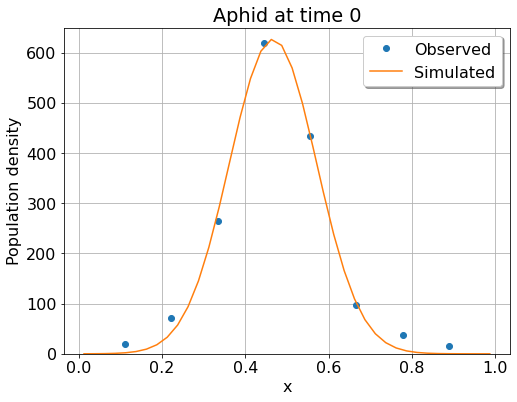

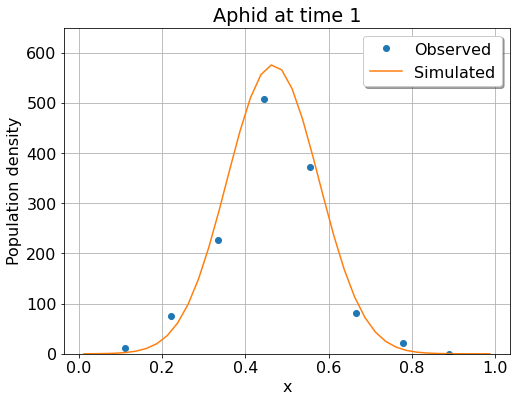

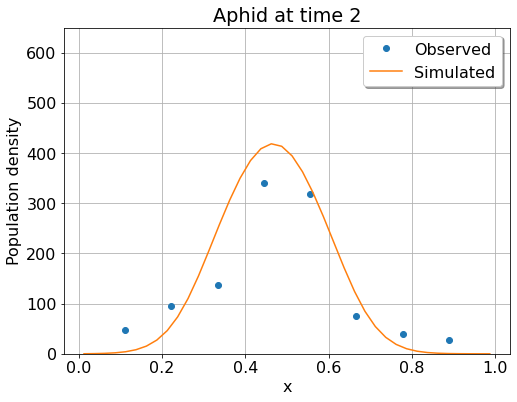

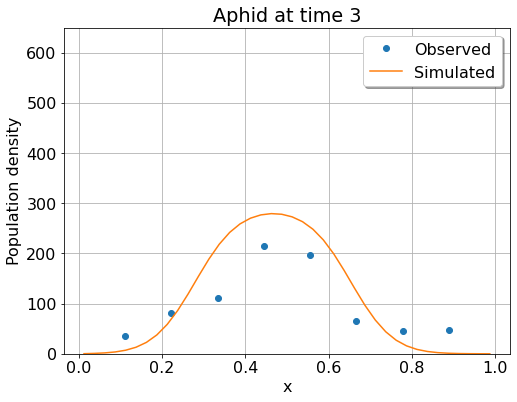

In [21]:
for time_index, aphid_simulation in enumerate(u_storage.data):
    if time_index in time_indices_to_plot:
        plt.figure(figsize=(8, 6))
        plt.ylim([0, 650])

        idx_for_observed = time_labels_dict[time_index]  # we skip time 1/4
        aphid_observed = aphid_data[aphid_data.time == idx_for_observed].copy()
        plt.plot(aphid_observed.x.values, aphid_observed.density.values, 'o', label='Observed')
        plt.plot(x_points, aphid_simulation, '-', label='Simulated')

        plt.xlabel('x')
        plt.ylabel('Population density')
        plt.title(f'Aphid at time {idx_for_observed}')

        plt.grid(True)
        plt.legend(shadow=True)
        plt.show()

#### Ladybird beetles

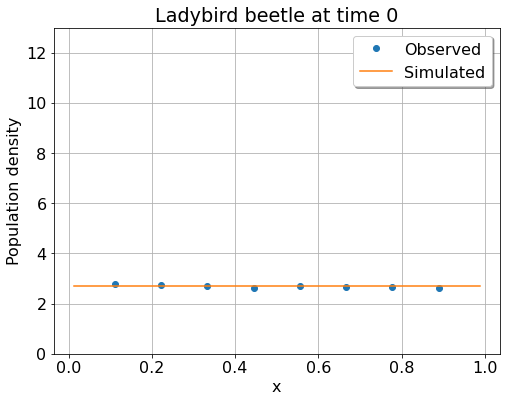

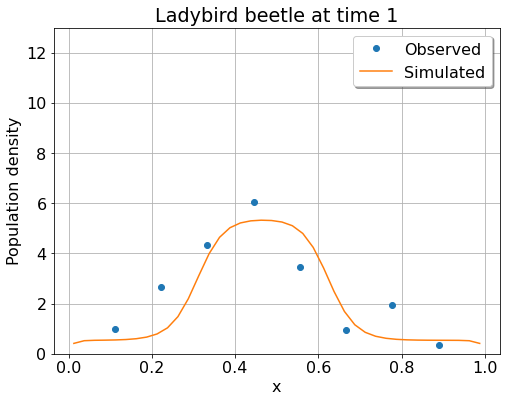

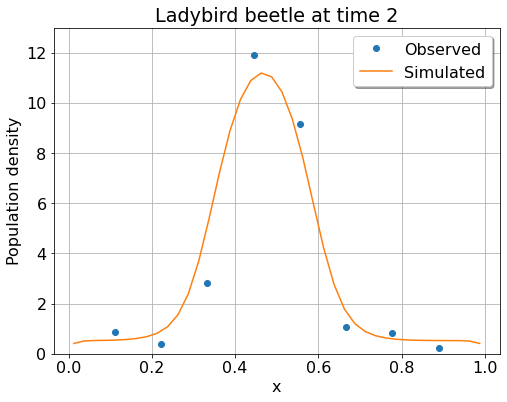

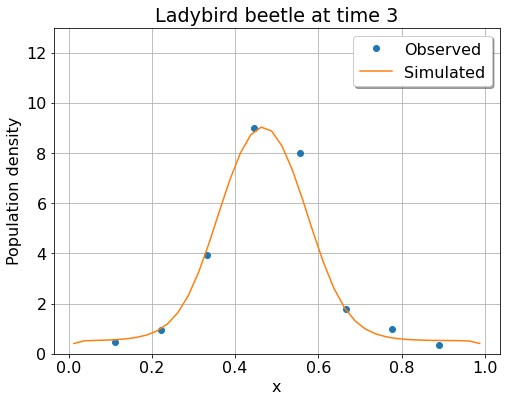

In [22]:
for time_index, ladybeetle_simulation in enumerate(v_storage.data):
    if time_index in time_indices_to_plot:
        plt.figure(figsize=(8, 6))
        plt.ylim([0, 13])

        idx_for_observed = time_labels_dict[time_index]  # we skip time 1/4
        ladybeetle_observed = ladybeetle_data[ladybeetle_data.time == idx_for_observed].copy()
        plt.plot(ladybeetle_observed.x.values, ladybeetle_observed.density.values, 'o', label='Observed')
        plt.plot(x_points, ladybeetle_simulation, '-', label='Simulated')

        plt.xlabel('x')
        plt.ylabel('Population density')
        plt.title(f'Ladybird beetle at time {idx_for_observed}')

        plt.grid(True)
        plt.legend(shadow=True)
        plt.show()

### Convenient functions for sensitivity analysis and calibration

In [23]:
def find_idx_nearest_value_in_array(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [24]:
x_observed = aphid_ic_data.x.values

x_points_indicies_simulation = list()
for x_value in x_observed:
    x_nearest_idx_in_simulation, x_value_simulation = find_idx_nearest_value_in_array( 
        x_points,
        x_value
    )
    x_points_indicies_simulation.append(x_nearest_idx_in_simulation)

In [25]:
x_points_indicies_simulation

[4, 8, 13, 17, 22, 26, 31, 35]

In [26]:
x_points[x_points_indicies_simulation]

array([0.1125, 0.2125, 0.3375, 0.4375, 0.5625, 0.6625, 0.7875, 0.8875])

In [27]:
def lotka_volterra_resp1_solver(
    Du=0.67e-3, 
    Dv=0.21e-2,
    r1=0.136,
    r2=0.48e-3,
    p=0.032,
    i=11.0,
    e1=0.0012,
    e2=20.9,
    e3=0.009
):
    # Functional response (case A)
    f_function = f"+ {r1} * u - {r2} * u * u - {p} * u * v"  # don't forget to put + (or -) sign in the beginning
    g_function = f"+ {i} - ({e1} + {e2} * exp(- {e3} * u)) * v"

    # (Dirichlet) Boundary condition example
    bc_left = {"value": 0.0}  # both unknowns are set to zero, unfortunately
    bc_right = {"value": 0.0}
    bc = [bc_left, bc_right]

    # Definition of PDE system
    eq = PDE(
        {
            "u": f"{Du} * laplace(u)" + f_function,
            "v": f"{Dv} * laplace(v)" + g_function,
        },
        bc=bc  # comment here if you want to "free" the boundaries
    )

    # Defining the mesh
    x_min, x_max = 0, 1
    dx = 0.025
    num_points_in_x = int((x_max - x_min) / dx)
    grid = CartesianGrid(bounds=[[x_min, x_max]], shape=num_points_in_x)

    # Initialize state (Initial Conditions)
    u = ScalarField.from_expression(
        grid, 
        f"{scale_term} * exp(- 1.0 / 2.0 * ((x - {mu}) / {sigma}) ** 2.0)", 
        label="Prey"
    )
    v = ScalarField(grid, ladybeetle_ic, label="Predator")
    state = FieldCollection([u, v])  # state vector

    # Define time tracker
    storage = MemoryStorage()
    dt = 1e-2
    trackers = [
        storage.tracker(interval=0.25),  # store data every simulation time unit
    ]

    # Select backend solver
    solver = ScipySolver(eq, method='LSODA')  # SciPy solver

    # Setup solver
    controller = Controller(solver, t_range=[0, 2], tracker=trackers)
    solve = controller.run(state, dt=dt)
    
    # Creating solution stack to compare in calibration
    u_storage = storage.extract_field(0)
    v_storage = storage.extract_field(1)
    
    u_full_data = np.asarray(u_storage.data)
    v_full_data = np.asarray(v_storage.data)
    
    u_full_filter_time = np.take(u_full_data, time_indices_to_plot, axis=0)
    u_matching_observed = np.take(u_full_filter_time, x_points_indicies_simulation, axis=1)
    
    v_full_filter_time = np.take(v_full_data, time_indices_to_plot, axis=0)
    v_matching_observed = np.take(v_full_filter_time, x_points_indicies_simulation, axis=1)
    
    u_matching_observed_flat = u_matching_observed.flatten()
    v_matching_observed_flat = v_matching_observed.flatten()
    
    x_points = grid.axes_coords[0]
    
    return x_points, u_matching_observed_flat, v_matching_observed_flat

In [28]:
def calculate_least_squares_error_lotka_volterra(parameters, y_data, fitting_model):
    u_data, v_data = y_data
    
    _, u_result_flat, v_result_flat  = fitting_model(*parameters)

    u_residual = u_data - u_result_flat
    v_residual = v_data - v_result_flat

    u_weight = 1.0
    v_weight = 1.0e2

    u_term = u_weight * np.sum(u_residual ** 2.0)
    v_term = v_weight * np.sum(v_residual ** 2.0)

    num_of_data = u_residual.shape[0]
    objective_function = (u_term + v_term) / num_of_data
    
    return objective_function


def calculate_least_squares_error_lotka_volterra_sensitivity(y_data, fitting_model, parameters):
    u_data, v_data = y_data
    
    _, u_result_flat, v_result_flat  = fitting_model(*parameters)

    u_residual = u_data - u_result_flat
    v_residual = v_data - v_result_flat

    u_weight = 1.0
    v_weight = 1.0e2

    u_term = u_weight * np.sum(u_residual ** 2.0)
    v_term = v_weight * np.sum(v_residual ** 2.0)

    num_of_data = u_residual.shape[0]
    objective_function = (u_term + v_term) / num_of_data
    
    return objective_function


def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

### Sensitivity Analysis for Least-Squares objective function

In [29]:
from SALib.sample.morris import sample as ee_sample

Du = 0.67e-3
Dv = 0.21e-2
r1 = 0.136
r2 = 0.48e-3
p = 0.032
i = 11.0
e1 = 0.0012
e2 = 20.9
e3 = 0.009

mean_values_params = [
    Du, 
    Dv,
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3
]
params_perturbations = 0.25
problem_info = {
    'num_vars': len(mean_values_params),
    'names': ['Du', 'Dv', 'r1', 'r2', 'p', 'i', 'e1', 'e2', 'e3'],
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [30]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

u_data = aphid_data.density.values
v_data = ladybeetle_data.density.values

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = calculate_least_squares_error_lotka_volterra_sensitivity(
        [u_data, v_data], lotka_volterra_resp1_solver, parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 40/40 [02:39<00:00,  3.99s/it]


In [31]:
from SALib.analyze.morris import analyze as ee_analyze

Si_list = list()
Si_dict = dict()
df_Si = pd.DataFrame(columns=[*problem_info['names']])
Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

,$\mu^*$
e3,0.286379
p,0.182843
i,0.146607
r1,0.139051
r2,0.118379
e2,0.103033
Du,0.017755
Dv,0.00586654
e1,8.76168e-05


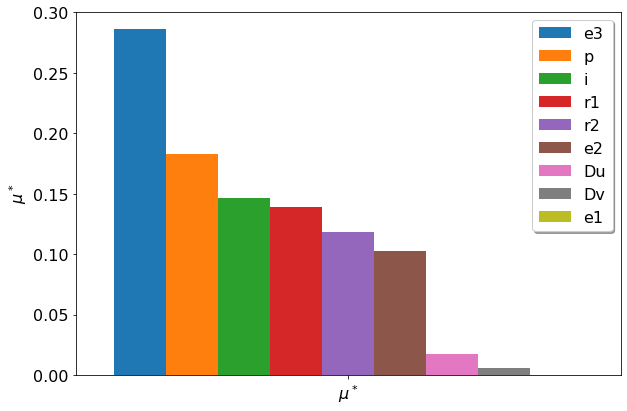

In [32]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("sensitivity_least_squares.png", dpi=300)
plt.show()

### Deterministic calibration

In [ ]:
parameters_bounds = [
    (1e-5, 1),  # Du
#     (1e-5, 1),  # Dv
#     (1e-5, 1),  # r1
#     (1e-5, 1),  # r2
#     (1e-5, 1),  # p
#     (1e-5, 20), # i
#     (1e-5, 1),  # e1
#     (1e-5, 30), # e2
#     (1e-5, 1),  # e3
]
u_data = aphid_data.density.values
v_data = ladybeetle_data.density.values

result_lotka_volterra_resp1 = optimize.differential_evolution(
    calculate_least_squares_error_lotka_volterra, 
    bounds=parameters_bounds, 
    args=([u_data, v_data], lotka_volterra_resp1_solver), 
    popsize=15,
    strategy='best1bin',
    tol=1e-3,
    recombination=0.7,
    maxiter=500,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1
)

print(result_lotka_volterra_resp1)